In [1]:
# Libraries for ML work:

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Variables in the code:

%env AWS_REGION = "region" 
%env AWS_ACCESS_KEY_ID = "key"
%env AWS_SECRET_ACCESS_KEY = "secret"

token = "token"

In [3]:
import os
import findspark
from pyspark.sql import *
from pyspark import SparkConf

findspark.init()

conf = SparkConf()
# we need iceberg libraries and the nessie sql extensions
conf.set(
    "spark.jars.packages",
    f"org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.0.0,org.projectnessie:nessie-spark-extensions-3.3_2.12:0.44.0,software.amazon.awssdk:bundle:2.17.178,software.amazon.awssdk:url-connection-client:2.17.178",
)
# ensure python <-> java interactions are w/ pyarrow
conf.set("spark.sql.execution.pyarrow.enabled", "true")
conf.set("spark.sql.catalog.arctic.io-impl","org.apache.iceberg.aws.s3.S3FileIO")

# create catalog named arctic as an iceberg catalog
conf.set("spark.sql.catalog.arctic", "org.apache.iceberg.spark.SparkCatalog")

# tell the catalog that its a Nessie catalog
conf.set("spark.sql.catalog.arctic.catalog-impl", "org.apache.iceberg.nessie.NessieCatalog")

# set the location for the catalog to store data. Spark writes to this directory
conf.set("spark.sql.catalog.arctic.warehouse", "s3://bucket/")

# set the location of the Arctic server.
conf.set("spark.sql.catalog.arctic.uri", "https://nessie.dremio.cloud/v1/..")

# default branch for Arctic catalog to work on
conf.set("spark.sql.catalog.arctic.ref", "main")

# Authentication mechanism. Here, we use AWS with BEARER
conf.set("spark.sql.catalog.arctic.authentication.type", "BEARER")
conf.set("spark.sql.catalog.arctic.authentication.token", token)

# enable the extensions for both Nessie and Iceberg
conf.set(
    "spark.sql.extensions",
    "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions,org.projectnessie.spark.extensions.NessieSparkSessionExtensions",
)

# finally, start up the Spark server
spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Running")

:: loading settings :: url = jar:file:/home/docker/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/docker/.ivy2/cache
The jars for the packages stored in: /home/docker/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.3_2.12 added as a dependency
org.projectnessie#nessie-spark-extensions-3.3_2.12 added as a dependency
software.amazon.awssdk#bundle added as a dependency
software.amazon.awssdk#url-connection-client added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-822ae2c8-f77b-4539-a81e-9d44200cfcfd;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.3_2.12;1.0.0 in central
	found org.projectnessie#nessie-spark-extensions-3.3_2.12;0.44.0 in central
	found org.scala-lang#scala-reflect;2.12.17 in central
	found org.projectnessie#nessie-spark-extensions-grammar;0.44.0 in central
	found org.projectnessie#nessie-spark-antlr-runtime;0.44.0 in central
	found org.antlr#antlr4-runtime;4.11.1 in central
	found org.projectnessie#nessie-spark-extensions-base_2.12;0.44.0 in central
	found org.projectness

22/11/23 22:02:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/23 22:03:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/23 22:03:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/23 22:03:36 ERROR Inbox: Ignoring error
java.lang.NullPointerException
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$register(BlockManagerMasterEndpoint.scala:579)
	at org.apache.spark.storage.BlockManagerMasterEndpoint$$anonfun$receiveAndReply$1.applyOrElse(BlockManagerMasterEndpoint.scala:121)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:103)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100)
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75)
	at org.apache.spark.rpc.netty.MessageLoop$$anon$1.run(MessageLoop.scala:41)
	at java.base/java.util.concurrent.Executo

# Create a name tagged dataset

In [ ]:
spark.sql("CREATE TABLE arctic.telco.churn_oct_training AS SELECT * FROM arctic.telco.churn_oct_data")

In [7]:
spark.sql("CREATE TAG Oct_data IN arctic")

DataFrame[refType: string, name: string, hash: string]

# Check the count of records in this dataset

In [12]:
spark.sql("SELECT COUNT(*) FROM arctic.telco.churn_oct_training LIMIT 5").toPandas()

,count(1)
0,935


# Hypothetical scenario: New ETL Data getting ingested

In [11]:
spark.sql(
    """CREATE OR REPLACE TEMPORARY VIEW new_train_data USING csv
            OPTIONS (path "newtrainingdata.csv", header true)"""
)

DataFrame[]

In [13]:
spark.sql("INSERT INTO arctic.telco.churn_oct_training SELECT * FROM new_train_data")

DataFrame[]

# Create a new tag for the new data set

In [14]:
spark.sql("CREATE TAG Nov_data IN arctic")

DataFrame[refType: string, name: string, hash: string]

# Check the count of records in this dataset. The count should have increased with the new data

In [15]:
spark.sql("SELECT COUNT(*) FROM arctic.telco.churn_oct_training LIMIT 5").toPandas()

,count(1)
0,1235


# Use the TAGs: 'Oct_data' & 'Nov_data' for our ML repro task

In [76]:
spark.sql("USE REFERENCE Nov_data IN arctic")

DataFrame[refType: string, name: string, hash: string]

In [77]:
# we query the dataset that we got from the main branch
spark.sql("SELECT COUNT(*) FROM arctic.telco.churn_oct_training LIMIT 5").toPandas()

,count(1)
0,1235


In [78]:
# read the data into a dataframe for starting building the model
df_telco_new = spark.read.table("arctic.telco.churn_oct_training").toPandas()

In [79]:
df_telco_new.head()

,State,Account_length,Area_code,International_plan,Voicemail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,UT,116,415,No,Yes,24,232.9,90,39.59,152.1,94,12.93,344.3,82,15.49,10.7,6,2.89,1,FALSE
1,LA,69,415,No,Yes,37,155.0,98,26.35,142.4,105,12.1,143.7,117,6.47,5.9,4,1.59,1,FALSE
2,ID,135,510,No,No,0,154.4,130,26.25,203.8,90,17.32,158.7,59,7.14,11.8,3,3.19,0,FALSE
3,KY,73,510,No,No,0,234.7,102,39.9,195.7,110,16.63,253.4,71,11.4,8.4,8,2.27,2,FALSE
4,MI,48,415,No,No,0,240.0,88,40.8,141.0,117,11.99,128.9,137,5.8,7.1,9,1.92,1,FALSE


In [80]:
df_telco_new.drop(['State', 'Area_code'], axis=1, inplace=True)

In [81]:
# dummy categorical data
df_telco_new['International_plan']=df_telco_new['International_plan'].replace(['No','Yes'],[0,1])
df_telco_new['Voicemail_plan']=df_telco_new['Voicemail_plan'].replace(['No','Yes'],[0,1])
df_telco_new['Churn']=df_telco_new['Churn'].replace(['FALSE', 'TRUE'],[0,1])

In [82]:
#prepare data 
target = df_telco_new.iloc[: , -1].values
features = df_telco_new.iloc[: , : -1].values

In [83]:
target.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [84]:
# divide train & test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=101)

In [85]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                max_depth=8, min_samples_split=2, 
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                max_features=None, max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                bootstrap=True, oob_score=False, 
                                warm_start=False, class_weight=None)

In [86]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [87]:
# evaluate the model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

acc                 = accuracy_score(y_test, predictions)
classReport         = classification_report(y_test, predictions)
confMatrix          = confusion_matrix(y_test, predictions) 
        
print(); print('Evaluation of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)


Evaluation of the trained model: 

Accuracy :  0.9271255060728745

Confusion Matrix :
 [[209   1]
 [ 17  20]]

Classification Report :
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       210
           1       0.95      0.54      0.69        37

    accuracy                           0.93       247
   macro avg       0.94      0.77      0.82       247
weighted avg       0.93      0.93      0.92       247



<AxesSubplot: >

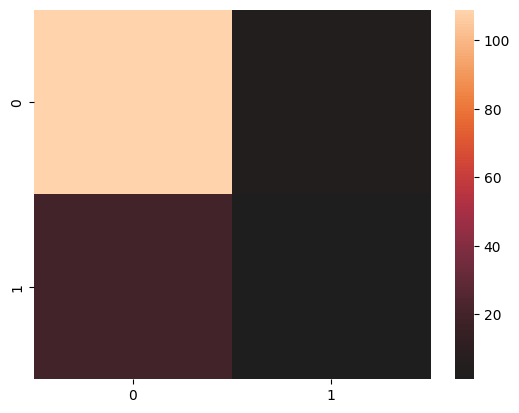

In [22]:
import seaborn as sns
sns.heatmap(confMatrix, center = True)